In [1]:
#%load_ext autoreload
#%autoreload 2

In [4]:
%matplotlib inline
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import simulators.cosmic_shear.cosmic_shear as cosmic_shear
import ndes.nde as nde
import distributions.priors as priors

In [5]:
### SET UP FOR SIMULATION CODE ###

# n(z)
nz = 10
pz = np.loadtxt('simulators/cosmic_shear/pz.dat')
z = pz[0,:]
pz_fid = [0]*nz
for i in range(1, nz+1):
    pz_fid[i-1] = interpolate.InterpolatedUnivariateSpline(z, pz[i,:])

# Set up fiducial parameters and binning
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
nz = 10
npar = 5
n_data = 5

# Define the priors
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])
prior_mean = theta_fiducial
sigmas = np.zeros(npar)
sigmas[0:5] = np.array([0.1, 0.1, 0.05, 0.3, 0.3])
Q = np.eye(npar)*sigmas**2
Qinv = np.linalg.inv(Q)
prior_args = [prior_mean, Q, lower, upper]

# Parameter names and ranges for plotting  
names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s']
labels =  ['\\Omega_m', 'S_8', '\\Omega_b', 'h', 'n_s']
ranges = {'\Omega_m':[lower[0], upper[0]], 'S_8':[lower[1],upper[1]],'\Omega_b':[lower[2],upper[2]],
            'h':[lower[3],upper[3]],'n_s':[lower[4],upper[4]]}

# Scale binning
lmax = 3000
lmin = 10
modes_edges = np.logspace(np.log10(lmin), np.log10(lmax), 11)
modes = (modes_edges[0:-1] + modes_edges[1:])/2
l = np.arange(lmin, lmax)
nl = np.array([sum((2*l[(l >= modes_edges[i])*(l < modes_edges[i+1])] + 1)) for i in range(len(modes))], dtype=int)

# Number of effective modes
A_sky = 15000*(np.pi/180)**2
f_sky = A_sky/(4*np.pi)
nl = np.array(nl*f_sky, dtype=int)

# Noise covariance
sigma_e = 0.3
nbar = 3*(60*180./np.pi)**2
N = (sigma_e**2/nbar)*np.eye(nz)

# Fiducial power spectrum
C = cosmic_shear.power_spectrum(theta_fiducial, pz_fid, modes, N)
Cinv = np.array([np.linalg.inv(C[:,:,l]) for l in range(len(modes))]).T

# Derivative of power spectrum
h = np.array(abs(theta_fiducial[0:5])*np.array([0.05, 0.05, 0.05, 0.05, 0.05]))
dCdt = np.zeros((npar, nz, nz, len(modes)))

# Derivatives wrt cosmological parameters
for i in range(npar):
    theta_plus = np.copy(theta_fiducial)
    theta_plus[i] += h[i]
    theta_minus = np.copy(theta_fiducial)
    theta_minus[i] -= h[i]
    
    Cp = cosmic_shear.power_spectrum(theta_plus, pz_fid, modes, np.zeros((nz, nz)))
    Cm = cosmic_shear.power_spectrum(theta_minus, pz_fid, modes, np.zeros((nz, nz)))
    C0 = cosmic_shear.power_spectrum(theta_fiducial, pz_fid, modes, np.zeros((nz, nz)))

    dCdt[i, :, :, :] = (Cp - Cm)/(2*h[i])

# Fisher matrix
F, Finv, fisher_errors = cosmic_shear.fisher_matrix(Cinv, dCdt, npar, nl, Qinv)

In [6]:
# Define the simulator function: takes parameters, spits out simulated data
# Should have the form: simulator(parameters, args) -> simulated dataset
simulator = cosmic_shear.simulate
simulator_args = [pz_fid, modes, N, nl]

In [7]:
# Define the compression function: takes data, spits out compressed summaries
# Should have the form compressor(data, args) -> compressed summaries
# NB: compression should be set-up like a quasi maximum-likelihood estimator
compressor = cosmic_shear.score
compressor_args = [Finv, theta_fiducial, prior_mean, Qinv, Cinv, dCdt, nl]

In [8]:
# Data vector
# Simulate some cosmic shear data
data = compressor(cosmic_shear.power_spectrum(theta_fiducial, pz_fid, modes, N), compressor_args)

In [7]:
# Create prior over parameters
prior = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

In [8]:
# Create the DELFI MDN object
n_components = 3
mdn = nde.DelfiMixtureDensityNetwork(data, prior, [lower, upper], Finv, theta_fiducial, n_components, n_hidden = [50, 50], activations = [tf.nn.tanh, tf.nn.tanh], names = names, labels = labels, ranges = ranges)

Generating pre-training data...
Training on the pre-training data...


HBox(children=(IntProgress(value=0, description='Epochs'), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=450), HTML(value='')))


Done.
Sampling approximate posterior...


/Users/jalsing/Dropbox (Simons Foundation)/science/delfi/DELFI_TOM/delfi/ndes/nde.py:182: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/Users/jalsing/Dropbox (Simons Foundation)/science/delfi/DELFI_TOM/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  return np.log(like)


Done.
Saving fish_pretrain_post.pdf


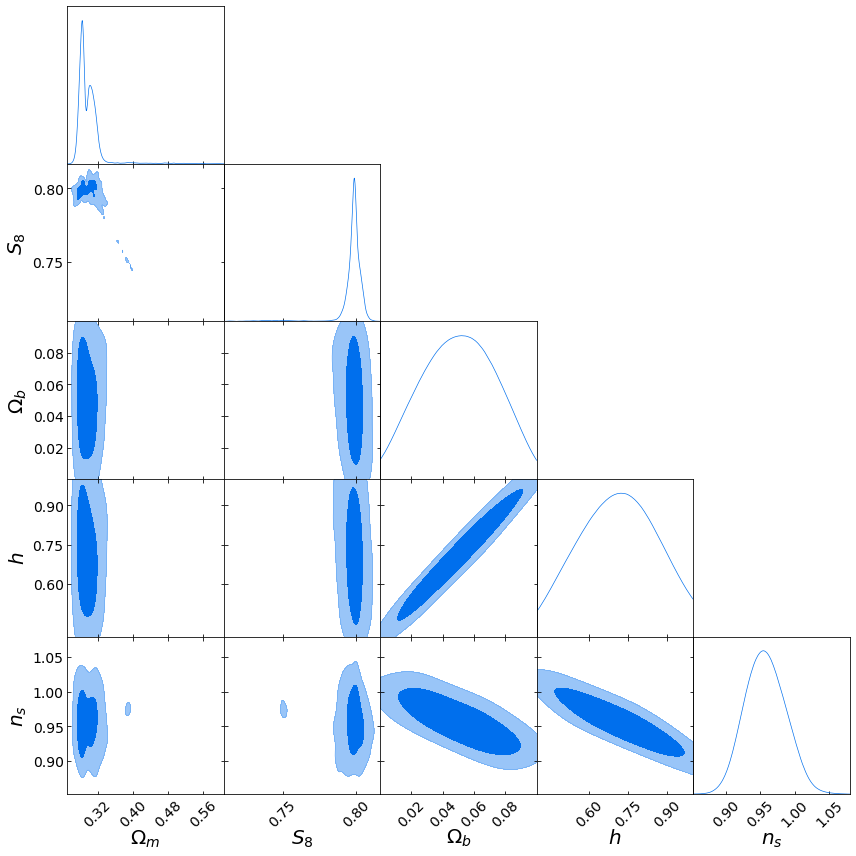

In [ ]:
# Do the Fisher pre-training
mdn.sess.run(tf.global_variables_initializer())
mdn.fisher_pretraining(50000, prior, epochs=100, epsilon = 1e-37)

Running initial 500 sims...
Done.


HBox(children=(IntProgress(value=0, description='Epochs'), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=5), HTML(value='')))


Sampling approximate posterior...


/Users/jalsing/Dropbox (Simons Foundation)/science/delfi/DELFI_TOM/delfi/ndes/nde.py:182: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/Users/jalsing/Dropbox (Simons Foundation)/science/delfi/DELFI_TOM/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  return np.log(like)


Done.
Saving seq_train_post_0.pdf


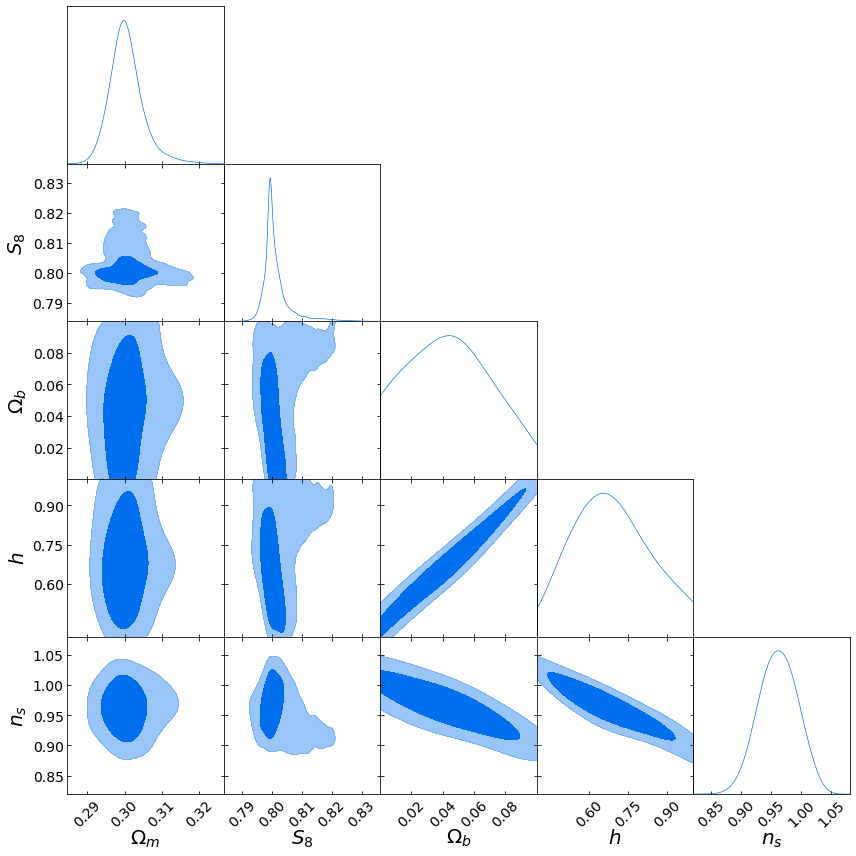

Population 1/15
Sampling proposal density...


/Users/jalsing/Dropbox (Simons Foundation)/science/delfi/DELFI_TOM/delfi/ndes/nde.py:182: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/Users/jalsing/Dropbox (Simons Foundation)/science/delfi/DELFI_TOM/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  return np.log(like)


Done.
Running 500 sims...
Done.


HBox(children=(IntProgress(value=0, description='Epochs'), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Batches', max=9), HTML(value='')))


Sampling approximate posterior...
Done.
Saving seq_train_post_1.pdf


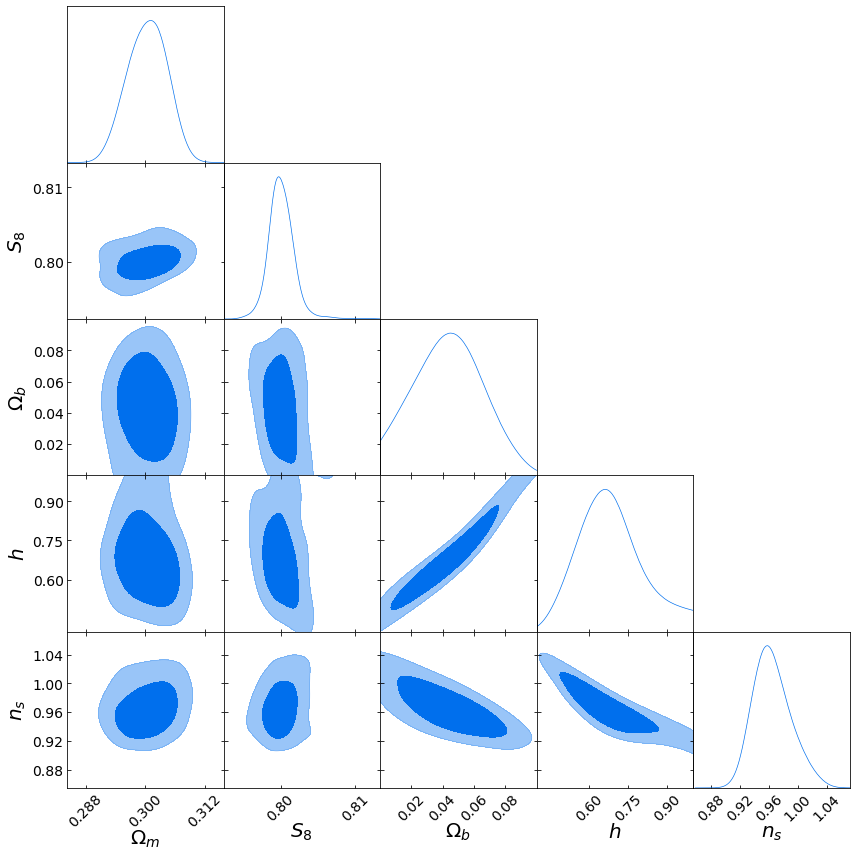

Population 2/15
Sampling proposal density...


/Users/jalsing/Dropbox (Simons Foundation)/science/delfi/DELFI_TOM/delfi/ndes/nde.py:182: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/Users/jalsing/Dropbox (Simons Foundation)/science/delfi/DELFI_TOM/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  return np.log(like)


Done.
Running 500 sims...
Simulator returns exception for parameter values: [0.3005743  0.79707576 0.048419   0.714825   0.95813261] (rank 0)


In [ ]:
# Proposal for the SNL
proposal = priors.TruncatedGaussian(theta_fiducial, 9*Finv, lower, upper)

# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 15

# Do the SNL training
mdn.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, proposal, epsilon = 1e-37, simulator_args=simulator_args, compressor_args=compressor_args)

In [ ]:
# Trace plot of the loss as a function of the number of simulations
plt.scatter(mdn.n_sim_trace, mdn.loss_trace, s = 20)
plt.plot(mdn.n_sim_trace, mdn.loss_trace, color = 'red')
plt.xlim(0, mdn.n_sim_trace[-1])
plt.xlabel('number of simulations')
plt.ylabel('loss')
plt.show()